In [1]:
#import libraries
import cv2

import numpy as np
import os

from IPython.display import display
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from time import time

## Working with images
Images are made up of a bunch of pixels. Each pixel has attributes such as location, color, and distance to other pixels.

There are numerous methods to display images in Python.

OpenCV for Python is an opensource library popular in the Machine Learning community. More info can be found at https://pypi.org/project/opencv-python/.  
Images in OpenCV are primarily numpy arrays. 

The code below below retrieves the image from the images folder and displays in a popup window.  Click on the image and then press any key on your keyboard to close it.

### Note for Jetson Nano

This method works fine for viewing images locally but when viewing through a Jupyter Notebook on the Nano, you will not be able to view the image in  popup window. The workaround is to combine cv2 with iPython, Matplotlib, or ipywidget to render images or vidoes.

In [3]:
#Display an image locally in a popup window using Cv2 imshow
img3 = cv2.imread('images/aqualung.jpg')
cv2.imshow('my image', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()

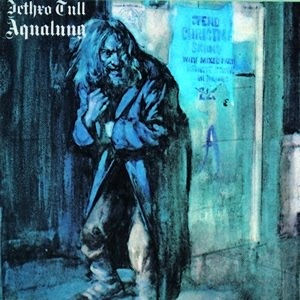

In [4]:
#Display an image using iPython dislay
#import libraries
import cv2

import numpy as np
import os

from IPython.display import display
from PIL import Image
img3 = cv2.imread('images/aqualung.jpg')
display(Image.fromarray(img3))

The next two blocks create a random image, writes them to file and displays them

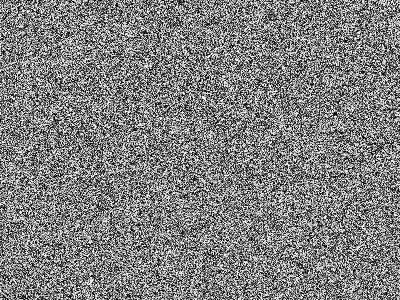

In [5]:
# Make an array of 120,000 random bytes.
randomByteArray = bytearray(os.urandom(120000))
flatNumpyArray = np.array(randomByteArray)

# Convert the array to make a 400x300 grayscale image.
grayImage = flatNumpyArray.reshape(300, 400)
cv2.imwrite('images/RandomGray.png', grayImage)
grayImage3 = cv2.imread('images/RandomGray.png')

display(Image.fromarray(grayImage3))

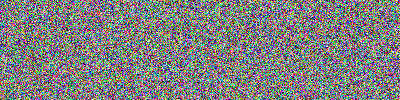

In [6]:
# Convert the array to make a 400x100 color image and write to file.
bgrImage = flatNumpyArray.reshape(100, 400, 3)
img = cv2.imwrite('images/RandomColor.png', bgrImage)
#read local image
img2 = cv2.imread('images/RandomColor.png') # with the OpenCV function imread(), the order of colors is BGR (blue, green, red).
display(Image.fromarray(img2))

Matplotlib can also be used to display images with notebook along with the %matplotlib inline decorator
Below is an example showing the same image using matplotlib

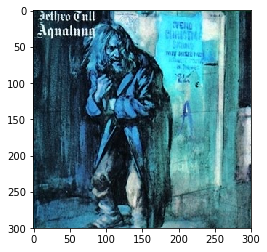

In [7]:
plt.imshow(img3)
plt.show()

## Matplotlib
And like iPython display, you can combine cv2 operations and use  Matplotlib to show the image. 

In this next codeblock, we use cv2 to transform the image and then show it as a plot. We also remoted the ticks on the x and y axis.

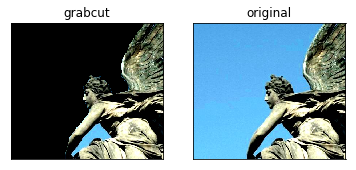

In [8]:
original = cv2.imread('images/statue_small.jpg')
img = original.copy()
mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

rect = (100, 1, 421, 378)
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("grabcut")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.xticks([])
plt.yticks([])

plt.show()


Here are the plots with the the ticks. 

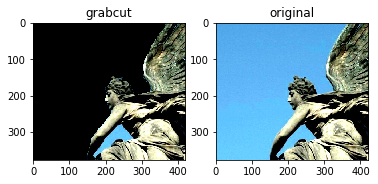

In [9]:
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("grabcut")

plt.subplot(122)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("original")

plt.show()

## Using ipywidgets

Finally, you an use an ipywidget to display the image. You will need to convert the image from an array to bytes.

ipywidgets are great to use for displaying images and videos remotely within a Jupyter Notebook.

In the code below, we are displaying the original image of the statue that we read in using the CV2 in the previous code block.

In [10]:
import ipywidgets
from IPython.display import display

def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

image_widget = ipywidgets.Image(format='jpeg')

image_widget.value = bgr8_to_jpeg(original)

display(image_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

### PyCuda
Up until now, all of the image processing has used the CPU.  Let's look at how can process images on the GPU using PyCuda
Here we will convert a color tif image to black and white.

Let's import our pycuda libraries.
We will use openCv to read in the image and ipywidgets to display the images

In [2]:
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import cv2
import ipywidgets
from IPython.display import display

#convert image to jpg for display
def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

Now lets take an image and pass it to the GPU and perform the computation to convert the image to black and white

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 13 12:15:39 2018

@author: bhaumik
"""

#pass c code to perform work on GPU

mod = SourceModule \
    ( 
        '''
#include<stdio.h>
#define INDEX(a, b) a*256+b

__global__ void bgr2gray(float *d_result,float *b_img, float *g_img, float *r_img)
{
unsigned int idx = threadIdx.x+(blockIdx.x*(blockDim.x*blockDim.y));

unsigned int a = idx/256;
unsigned int b = idx%256;
d_result[INDEX(a, b)] = (0.299*r_img[INDEX(a, b)]+0.587*g_img[INDEX(a, b)]+0.114*b_img[INDEX(a, b)]);

}
  
  '''
      )
  
h_img = cv2.imread('lena_color.tif',1)

r_img = h_img[:, :, 2].reshape(65536).astype(np.float32)
h_result=r_img
#create instance of cuda function
bgr2gray = mod.get_function("bgr2gray")
#call pycuda function
bgr2gray(drv.Out(h_result), drv.In(b_img), drv.In(g_img),drv.In(r_img),block=(1024, 1, 1), grid=(64, 1, 1))

h_result=np.reshape(h_result,(256,256)).astype(np.uint8)
#display transformed image
image_widget = ipywidgets.Image(format='jpeg')
image_widget.value = bgr8_to_jpeg(h_result)
display(image_widget)
#original image
orgimage_widget = ipywidgets.Image(format='jpeg')
orgimage_widget.value = bgr8_to_jpeg(h_img)
display(orgimage_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

### Pycuda adding two images
Lets take the Lena image and combine with another image into one image

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 13 12:15:39 2018

@author: bhaumik
"""


mod = SourceModule \
    (
        """
                   
__global__ void add_num(float *d_result, float *d_a, float *d_b,int N)
{
 int tid = threadIdx.x + blockIdx.x * blockDim.x;	
	while (tid < N)
    {
 d_result[tid] = d_a[tid] + d_b[tid];
 if(d_result[tid]>255)
 {
 d_result[tid]=255;
 }
 tid = tid + blockDim.x * gridDim.x;
}
    }
  
  """
      )
  
img1 = cv2.imread('lena_color.tif',0)
img2 = cv2.imread('circles.png',0)

#print a
h_img1 = img1.reshape(65536).astype(np.float32)
h_img2 = img2.reshape(65536).astype(np.float32)
N = h_img1.size
h_result=h_img1
add_img = mod.get_function("add_num")
add_img(drv.Out(h_result), drv.In(h_img1), drv.In(h_img2),np.uint32(N),block=(1024, 1, 1), grid=(64, 1, 1))

h_result=np.reshape(h_result,(256,256)).astype(np.uint8)

image_widget = ipywidgets.Image(format='jpeg')
image_widget.value = bgr8_to_jpeg(h_result)
display(image_widget)


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

### OpenCV CUDA

OpenCV has some libaries that are CUDA enabled. There are reference guides and document but not yet a lot of specific examples in Python.  Most are in C.  For those libraries that are available to OpenCV CUDA and Python, using those libraries are very similar to Open CV in python except that you prefix with 'CUDA.'  There are also several processing steps to prepare the data and move the data from CPU to GPU.

Let's look at a simple example of using the CLAHE transformation in OpenCV. This first example is the CPU version.

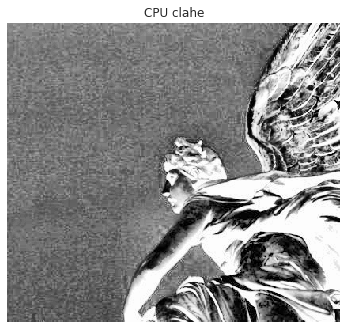

In [27]:
#CPU version
img = cv2.imread("images/statue_small.jpg", cv2.IMREAD_GRAYSCALE)

def plotImages(imgr):
    plt.imshow(imgr)
    plt.title("CPU clahe")
    plt.xticks([])
    plt.yticks([])
   
  

#contrast Limited Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
imgr = clahe.apply(img)

plotImages(imgr)


###OpenCV CUDA

Now let us look at the CUDA version of the CLAHE function.  
Notice that you first much format the data using cuda_GpuMat and then upload the dat to the GPU.

Then you call the CLAHE function prefixing it with cuda. The final step before displaying the image is to download the image back to the CPU. 

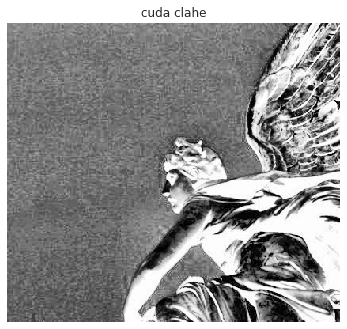

In [23]:
#reference https://learnopencv.com/getting-started-opencv-cuda-module/

def plotImages(img):
    plt.imshow(img)
    plt.title("cuda clahe")
    plt.xticks([])
    plt.yticks([])
  
img = cv2.imread("images/statue_small.jpg", cv2.IMREAD_GRAYSCALE)
src = cv2.cuda_GpuMat()
src.upload(img)

clahe = cv2.cuda.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
dst = clahe.apply(src, cv2.cuda_Stream.Null())

result = dst.download()

plotImages(imgr)

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)